### Installing Dependencies

In [7]:
# !pip install -U langchain-community

In [8]:
# !pip install langchain-docling

In [9]:
# !pip install langchain-huggingface

In [10]:
# !pip install docling

In [11]:
# !pip install langchain-pinecone

In [44]:
# !pip install langchain-groq


### Importing the required libraries

In [12]:
import os
from pathlib import Path
from PIL import Image
from io import BytesIO
import base64
from IPython.display import display, HTML
from langchain_docling import DoclingLoader
from langchain_docling.loader import ExportType
from docling.document_converter import DocumentConverter
from docling.datamodel.pipeline_options import (
    PdfPipelineOptions,
)
from docling.document_converter import PdfFormatOption
from docling.datamodel.base_models import InputFormat
from transformers import AutoTokenizer
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_core.prompts import PromptTemplate
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFaceEndpoint
from langchain_huggingface import ChatHuggingFace
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore
from langchain_core.runnables import RunnableParallel, RunnablePassthrough

### Parsing the provided document to Suitable Format(.txt,.md)

In [13]:
pipeline_options = PdfPipelineOptions(
    generate_page_images=True,
    images_scale = 1.00,
)
# maps the input file type to the specific processing configuration, allowing the converter to know: 1. What type of file it’s dealing with, 2. How it should handle that file type
format_options={InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)}

In [14]:
converter = DocumentConverter(format_options=format_options)
sources = ["/content/Balance Sheet.pdf",]

# 1. Dictionary comprehension approach
# Dictionary where it loops through each file in the sources, converter.convert(source) to process each document, .document is used to extract only the acutal content representation of the file
# stores it in a dictionary with the file path as the key
conversions = {source: converter.convert(source=source).document for source in sources}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
# Good for batch processing if you're dealing with many files.
# {
#     "/content/microsoftFY 2024.pdf": <Document object>,
#     "another_file.pdf": <Document object>,
# }

In [16]:
%%time
document_path = Path("/content/Balance Sheet.pdf")
#  2. Single conversion with explicit timing
result = converter.convert(document_path)
document = result.document

CPU times: user 1.92 s, sys: 43.9 ms, total: 1.97 s
Wall time: 1.98 s


In [17]:
document = result.document
print(document.export_to_text())

## Balance Sheet

As at March 31, 2022

` in '000

|                                                                                                                                                   | Schedule   | As at March 31, 2022   | As at March 31, 2021   |
|---------------------------------------------------------------------------------------------------------------------------------------------------|------------|------------------------|------------------------|
| CAPITAL AND LIABILITIES                                                                                                                           |            |                        |                        |
| Capital                                                                                                                                           | 1          | 5,545,541              | 5,512,776              |
| Reserves and surplus                                                                           

### Visual Inspection

In [18]:
def image_to_base64(image: Image.Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def display_page(content: str, image: Image.Image):
    html_template = f"""
    <div style="display: flex; align-items: flex-start; gap: 40px; font-family: monospace;">
        <div style="flex: 1; max-width: 45%;">
            <img src="data:image/png;base64,{image_to_base64(image)}" style="width: 100%; height: auto; padding: 5px;">
        </div>
        <div style="flex: 1; max-width: 45%; white-space: pre-wrap; padding: 10px;">
            <div style="word-wrap: break-word; max-width: 120ch;">
                {content}
            </div>
        </div>
    </div>
    """
    display(HTML(html_template))

In [19]:
n_pages = len(document.pages)
n_pages

1

In [20]:
pages = []
for page_num in range(1, n_pages + 1):
  pages.append(
      (
          document.export_to_markdown(page_no=page_num),
          document.pages[page_num].image.pil_image
      )
  )


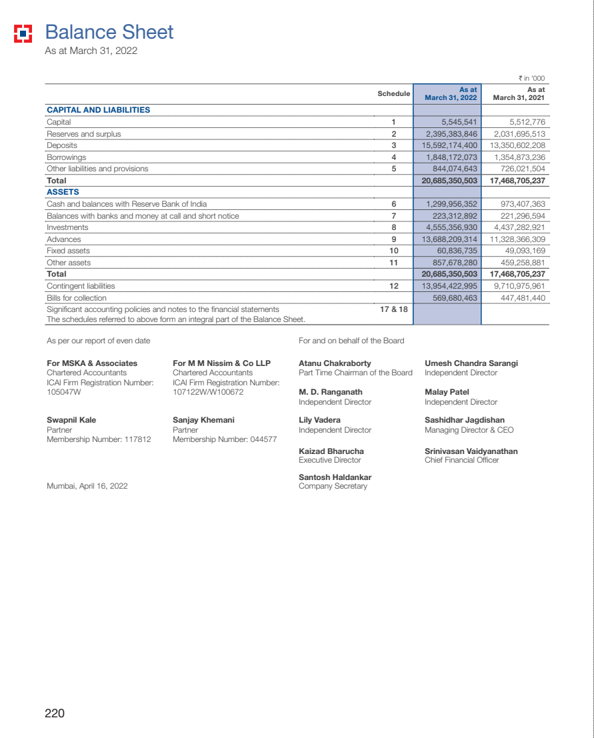

In [21]:
display_page(*pages[0])

### Define LLM model and Embedding model

In [23]:
embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_model = HuggingFaceEmbeddings(model_name=embeddings_model_path,)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

In [33]:
from langchain_groq import ChatGroq
GROQ_API_KEY = "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"

In [47]:
model = ChatGroq(groq_api_key=GROQ_API_KEY,model="llama-3.3-70b-versatile")

In [48]:
model.invoke("What is the capital of India?")

AIMessage(content='The capital of India is New Delhi.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 42, 'total_tokens': 51, 'completion_time': 0.032727273, 'prompt_time': 0.143026619, 'queue_time': 0.099342183, 'total_time': 0.175753892}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'stop', 'logprobs': None}, id='run--ae6d1919-ae41-4072-b0a3-a1d0a1d9af12-0', usage_metadata={'input_tokens': 42, 'output_tokens': 9, 'total_tokens': 51})

### Chunking the Docs

In [40]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=200)

all_chunks = {}
for source, document in conversions.items():
    full_text = document.export_to_text()
    chunks = text_splitter.split_text(full_text)
    all_chunks[source] = chunks

In [41]:
for source, chunks in all_chunks.items():
    print(f"{source}: {len(chunks)} chunks")

/content/Balance Sheet.pdf: 4 chunks


In [43]:
for source, chunks in all_chunks.items():
    print(f"\n=== Chunks from {source} ===")
    for i, chunk in enumerate(chunks, start=1):
        print(f"\n--- Chunk {i} ---\n{chunk}")


=== Chunks from /content/Balance Sheet.pdf ===

--- Chunk 1 ---
## Balance Sheet

As at March 31, 2022

` in '000

--- Chunk 2 ---
|                                                                                                                                                   | Schedule   | As at March 31, 2022   | As at March 31, 2021   |
|---------------------------------------------------------------------------------------------------------------------------------------------------|------------|------------------------|------------------------|
| CAPITAL AND LIABILITIES                                                                                                                           |            |                        |                        |
| Capital                                                                                                                                           | 1          | 5,545,541              | 5,512,776              |
| Reserves and s

In [54]:
# preparing chunks for use with PineCone
for source, chunks in all_chunks.items():
    docs = [Document(page_content=chunk, metadata={"chunk_id": i}) for i, chunk in enumerate(chunks)]

### Prompt Template and Chaining the Model and Prompt Template

In [58]:
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
    You are a highly knowledgeable financial assistant. Use only the information provided in the context below to answer the user's question. Do not use prior knowledge.

    If the context does not contain the information needed, respond with:
    "The answer is not available in the provided document."

    Use the following context to answer the question.
    ---
    Context:
    {context}
    ---

    Question: {question}

    Answer:
    """
)


In [59]:
chain = prompt | model

### Pine Cone Vector DataBase

In [51]:
os.environ["PINECONE_API_KEY"] = "pcsk_2RHjZi_JGNkT8eM8fPTate7MCSPPnz5iuc4rdgd9J3pgzAhUz41YvcaHuZiyzVhGiw3gry"
os.environ["PINECONE_ENVIRONMENT"] = "us-east-1"

pinecone_client = Pinecone(
    api_key=os.environ["PINECONE_API_KEY"],
    environment=os.environ["PINECONE_ENVIRONMENT"],
)

In [55]:
index_name = "tryme"
pinecone = PineconeVectorStore.from_documents(
    documents = docs,
    embedding = embeddings_model,
    index_name = index_name,
)

In [60]:
chain = (
    {"context" : pinecone.as_retriever(), "question":RunnablePassthrough()}
    |prompt
    |model
)

In [63]:
chain.invoke("Who is Atanu Chakraborty?")

AIMessage(content='Atanu Chakraborty is a Part Time Chairman of the Board and an Independent Director, but the specific company is not mentioned in the provided context.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 832, 'total_tokens': 866, 'completion_time': 0.123640687, 'prompt_time': 0.061725844, 'queue_time': 0.092177607, 'total_time': 0.185366531}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_6507bcfb6f', 'finish_reason': 'stop', 'logprobs': None}, id='run--a25ba3d9-c7bd-4819-a462-8dd2e4426e98-0', usage_metadata={'input_tokens': 832, 'output_tokens': 34, 'total_tokens': 866})